In [886]:
import numpy as np
import matplotlib.pyplot as plt
import glob, uproot
import matplotlib.cm as cm
from scipy.stats import poisson

In [887]:
### calculations for solid H-3

solid_T_rho = 0.316 ## g/cm^3
T_molar_mass = 3.016 ## amu
T_half_life = 12.32 ## years
T_last_ev_frac = 2.9e-13 ## fraction of decays in last eV
T_branching_ratio = 0.57 ## to bound molecular state

liquid_He_rho = 0.125 ## g/cm^3

estar_stopping_power = 3.092E+04 ## keV cm^2/g
T_Q = 18.6 ## keV
T_mean_eng = 5.7 ## keV

epsilon_0 = 55.26349406 ## e^2/(eV um)
e_to_Coul = 1.602e-19 ## C
eV_to_J = 1.602e-19 ## J
c_const = 3e8 # m/s
hbar = 1.055e-34 ## J s
k_b = 1.38e-23 ## J/K
mol_to_atom = 6.023e23 ## atoms/mol

solid_Xe_rho = 2.9 ## g/cm^3
solid_Ne_rho = 0.9 ## g/cm^3
Xe_molar_mass = 131.293 ## amu
Ne_molar_mass = 20.1797 ## amu
He_molar_mass = 4.0026 ## amu

In [888]:
## units (kludgy for now, should replace with a python package)
amu_to_g = 1.66e-24 
cm_to_m = 1e-2
g_to_ng = 1e9
m_to_um = 1e6
m_to_nm = 1e9
Ci_to_bq = 3.7e10
keV_to_eV = 1000
MeV_to_eV = 1e6
nm_to_um = 1e-3
um_to_cm = 1e-4
g_to_kg = 1e-3
um_to_nm = 1e3
umHg_to_Pa = 0.133322 ## um Hg to Pa
Pa_to_bar = 1e-5 # Pa to bar

In [889]:
## assume hexagonal lattice of T2 molecules, lattice parameters from 
# https://www.webelements.com/hydrogen/crystal_structure.html

## lattice parameters
a = 470e-12 # m
c = 340e-12 # m

## monolayer area density
area_density = solid_T_rho * c / cm_to_m # g/cm^2
print("Density per area [g/cm^2]: %.2e"%area_density)

Density per area [g/cm^2]: 1.07e-08


In [890]:
## calculate the tritium mass and activity for a solid tritium shell of given radius and thickness

rad_list = np.logspace(-6, -2, 100) ## radius in m
thick_list = np.logspace(np.log10(c), -4, 1000) ## thickness in m

mass_mat = np.zeros((len(rad_list), len(thick_list)))

for rad_idx, rad in enumerate(rad_list):
    for thick_idx, thick in enumerate(thick_list):

        if thick > rad:
            mass_mat[rad_idx, thick_idx] = -1
            continue 

        ## calculate the mass of tritium in a shell
        mass_mat[rad_idx, thick_idx] = 4/3 * np.pi * (rad**3 - (rad-thick)**3) * solid_T_rho / cm_to_m**3 # g

mass_mat[mass_mat < 0] = np.nan

target_mass = 200e-9 # g for 1 evt/day in last eV
T_tau = T_half_life * 365.25 * 24 * 3600 / np.log(2) # s
print("Decay rate [s^-1]: %.2e"%(1/T_tau))
specific_activity = 1/(T_molar_mass * T_tau * amu_to_g)
print("Specific activity [Bq/g]: %.2e"%specific_activity)

decay_mat = mass_mat * 1/ (T_molar_mass * amu_to_g * T_tau) # Bq

last_ev_mat = decay_mat * 24*3600 * T_last_ev_frac * T_branching_ratio ## counts per day in last eV

print('Target activity: ', target_mass*specific_activity/Ci_to_bq, 'Ci')

Decay rate [s^-1]: 1.78e-09
Specific activity [Bq/g]: 3.56e+14
Target activity:  0.0019248621489222255 Ci


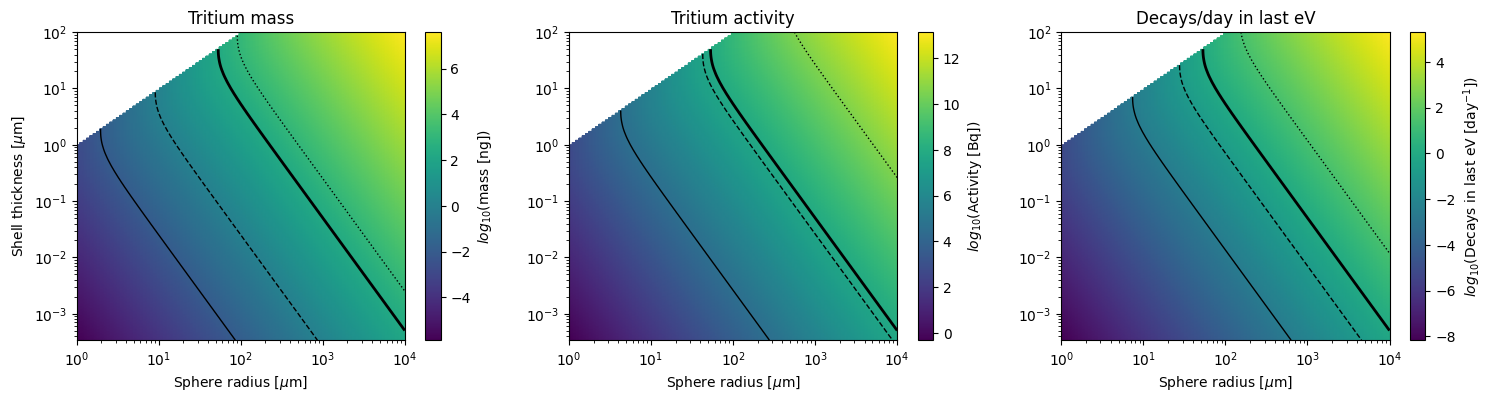

In [891]:
plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(mass_mat.T * g_to_ng), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(mass [ng])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[10e-12, 1e-9, 1e-6], colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Tritium mass")

plt.subplot(1, 3, 2)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(decay_mat.T), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
#plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(Activity [Bq])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
activity_rates = [1e-6*Ci_to_bq, 1e-3*Ci_to_bq, 1*Ci_to_bq]
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, decay_mat.T, levels=activity_rates, colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Tritium activity")

plt.subplot(1, 3, 3)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(last_ev_mat.T), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
#plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(Decays in last eV [day$^{-1}$])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
activity_rates = [1/365, 1/7, 24]
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, last_ev_mat.T, levels=activity_rates, colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Decays/day in last eV")

plt.savefig("plots/tritium_mass_activity.png", dpi=300, bbox_inches='tight')

plt.show()

In [892]:
## What shell thickness is possible (?)

## maybe ask what is equivalent to KATRIN

## naive nist estar vs shell thickness:
thick_list = np.logspace(-10, -2, 100) ## thickness in m
estar_eng_loss = thick_list/cm_to_m * estar_stopping_power * solid_T_rho


In [893]:
def get_colors_from_colormap(n, colormap_name='viridis'):
    """
    Select n colors evenly spaced from a given colormap.

    Parameters:
    - n (int): Number of colors to select.
    - colormap_name (str): Name of the matplotlib colormap.

    Returns:
    - List of RGB tuples.
    """
    colormap = cm.get_cmap(colormap_name, n)  # Get colormap with n discrete colors
    return [colormap(i) for i in range(n)]  # Extract colors

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_1709/1776003015.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap_name, n)  # Get colormap with n discrete colors


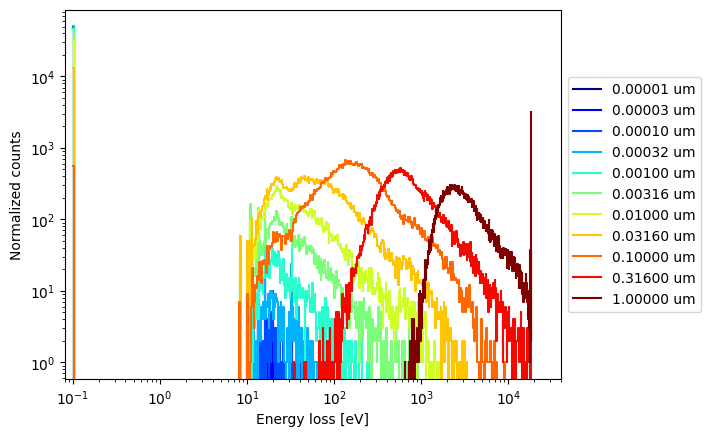

In [894]:
## g4-DNA energy loss

data_path = '/Users/dcmoore/Documents/g4vm/data/*'
folder_list = glob.glob(data_path)

sim_eng_loss = {}
sim_thick_list = []
sim_thick_range = []
unscattered_fraction = []

for j,folder in enumerate(folder_list):

    cf = folder.split('/')[-1]
    thick = float(cf[5:-2])
    sim_thick_list.append(thick)

    curr_files = glob.glob(folder + '/*.root')

    for file in curr_files:
    
        tot_eloss = []
        with uproot.open(file) as rf:
            
            if(len(tot_eloss) == 0):
                tot_eloss = np.array(rf['EnergyDeposition']['EnergyLost']) * MeV_to_eV
            else:
                tot_eloss = np.concatenate((tot_eloss, np.array(rf['EnergyDeposition']['EnergyLost']) * MeV_to_eV))

    sim_eng_loss[thick] = tot_eloss
    sim_thick_range.append([thick, np.quantile(tot_eloss,0.5), np.min(tot_eloss), np.max(tot_eloss), np.quantile(tot_eloss,0.05), np.quantile(tot_eloss,0.95)])

    N_unscatt = np.sum(tot_eloss < 1e-3)
    unscattered_fraction.append([N_unscatt/len(tot_eloss), np.sqrt(N_unscatt)/len(tot_eloss)]) ## fraction of events that didn't deposit energy

sim_thick_range = np.array(sim_thick_range)
unscattered_fraction = np.array(unscattered_fraction)

sim_thick_list = sorted(sim_thick_list)
plt.figure()
bins1 = np.linspace(1e-3, 20e3, int(1e6))
bins2 = np.linspace(1e-3, 20e3, int(1e4))
colors = get_colors_from_colormap(len(sim_thick_list), 'jet')
for tidx, thick in enumerate(sim_thick_list):

    #if(thick not in [1, 10,100]): continue

    if(thick < 20):
        bins = bins1
    else:
        bins = bins2
    #h, b = np.histogram(sim_eng_loss[thick], bins=bins) ## offset to put min bin at 1 meV
    h, b = np.histogram(np.log10(sim_eng_loss[thick]+1e-1), bins=500) ## offset to put min bin at 1 meV
    #h = h/np.max(h[b[:-1] > -2])
    plt.step(10**(b[:-1]), h, where='post', label='%.5f um'%(thick*nm_to_um), color=colors[tidx])
ax = plt.gca()
ax.set_xscale('log')
plt.xlim(8e-2, 4e4)
ax.set_yscale('log')
#plt.ylim(0,1.1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Energy loss [eV]")
plt.ylabel("Normalized counts")

plt.savefig("plots/energy_loss_distrib.pdf", bbox_inches='tight')
plt.show()

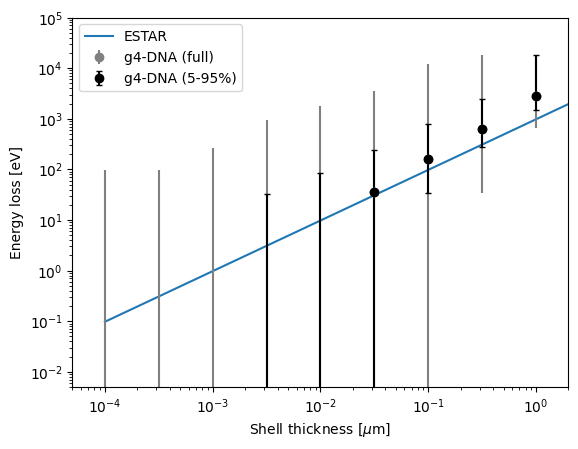

In [919]:
plt.figure()
plt.loglog(thick_list*m_to_um, estar_eng_loss * keV_to_eV, label="ESTAR")

err_tot_lo = sim_thick_range[:,1] - sim_thick_range[:,2]
err_tot_hi = sim_thick_range[:,3] - sim_thick_range[:,1]
plt.errorbar(sim_thick_range[:,0]*nm_to_um, sim_thick_range[:,1], yerr=[err_tot_lo, err_tot_hi], fmt='o', color='gray', label="g4-DNA (full)")
err_tot_lo = sim_thick_range[:,1] - sim_thick_range[:,4]
err_tot_hi = sim_thick_range[:,5] - sim_thick_range[:,1]
plt.errorbar(sim_thick_range[:,0]*nm_to_um, sim_thick_range[:,1], yerr=[err_tot_lo, err_tot_hi], fmt='o', color='k', capsize=2, label="g4-DNA (5-95%)")

plt.xlim(5e-5, 2)
plt.ylim(5e-3, 1e5)
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Energy loss [eV]")
plt.legend()

plt.savefig("plots/energy_loss_vs_thick.pdf", bbox_inches='tight')
plt.show()

In [896]:
## now use nominal cross section to figure out what fraction scatter

sigma_inelastic = 3.4e-18 # cm^2

num_density = solid_T_rho/(T_molar_mass * amu_to_g) ## volume number density in cm^{-3}

print("Number density is: [cm^{-3}] ", num_density)

## first the column density
column_density = num_density * thick_list/cm_to_m # cm^{-2}
KATRIN_cd = 5e17 # cm^{-2}

## mean number of scatters
mean_num_scatters = column_density * sigma_inelastic

fraction_unscattered = poisson.cdf(0, mean_num_scatters)


Number density is: [cm^{-3}]  6.311719024639672e+22


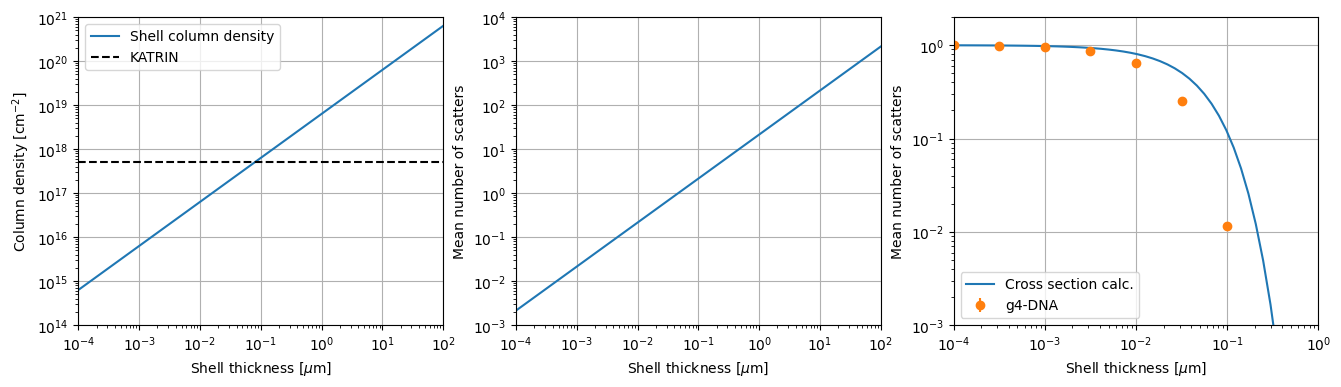

In [897]:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
plt.loglog(thick_list*m_to_um, column_density, label="Shell column density")
plt.plot(thick_list*m_to_um, KATRIN_cd*np.ones_like(thick_list), 'k--', label="KATRIN")
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Column density [cm$^{-2}$]")
plt.grid(True)
plt.xlim(1e-4, 100)
plt.ylim(1e14, 1e21)
plt.legend()


plt.subplot(1, 3, 2)
plt.loglog(thick_list*m_to_um, mean_num_scatters)
plt.xlim(1e-4, 100)
plt.ylim(1e-3, 1e4)  
plt.grid(True) 
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Mean number of scatters")

plt.subplot(1, 3, 3)
plt.loglog(thick_list*m_to_um, fraction_unscattered, label="Cross section calc.")
plt.errorbar(sim_thick_range[:,0]*nm_to_um, unscattered_fraction[:,0], yerr=unscattered_fraction[:,1], fmt='o', label="g4-DNA")
plt.xlim(1e-4, 1)
plt.ylim(1e-3, 2)  
plt.grid(True) 
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Mean number of scatters")
plt.legend(loc = "lower left")

plt.savefig("plots/num_scatters_vs_thick.pdf", bbox_inches='tight')

plt.show()

In [898]:
## for different shell thicknesses, how many spheres do we need as a function of radius to get 200 ng

rad_list_um = rad_list * m_to_um
shell_thick_list = [0.01, 0.1] #um

n_spheres = np.zeros((len(rad_list), len(shell_thick_list)))
heating_rate = np.zeros((len(rad_list), len(shell_thick_list)))
for rad_idx, rad in enumerate(rad_list_um):

    for thick_idx, thick in enumerate(shell_thick_list):

        ## calculate the mass of tritium in a shell
        mass = 4/3 * np.pi * (rad**3 - (rad-thick)**3) * um_to_cm**3 * solid_T_rho # g
    
        n_spheres[rad_idx, thick_idx] = np.max([target_mass/mass, 1])

        heating_rate[rad_idx, thick_idx] = mass * 1/ (T_molar_mass * amu_to_g * T_tau) * T_mean_eng * keV_to_eV * eV_to_J

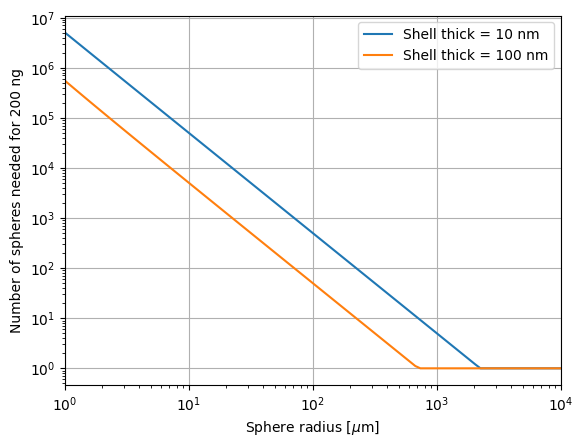

In [899]:
plt.figure()
for thick_idx, thick in enumerate(shell_thick_list):
    plt.loglog(rad_list_um, n_spheres[:, thick_idx], label='Shell thick = %d nm'%(thick*um_to_nm))

plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Number of spheres needed for 200 ng")
plt.grid(True)
plt.legend()
plt.xlim(1,1e4)

plt.savefig("plots/num_spheres_vs_rad.pdf", bbox_inches='tight')


In [900]:
## first, what total charge is needed as a function of sphere radius to get to Q-value

r0_list = np.logspace(1, 4, 1000) # um

q_Q = T_Q * keV_to_eV * 4*np.pi*epsilon_0 * r0_list ## total charge needed
dQ_per_eV = q_Q - ((T_Q * keV_to_eV - 1) * 4*np.pi*epsilon_0 * r0_list)

vol = 4/3 * np.pi * (r0_list * um_to_cm)**3 # cm^3
Q_to_m_Xe = q_Q*e_to_Coul/(vol * solid_Xe_rho * g_to_kg) ## charge to mass ratio, C/kg
Q_to_m_Ne = q_Q*e_to_Coul/(vol * solid_Ne_rho * g_to_kg) ## charge to mass ratio, C/kg

Ca_Q_to_m = 2.5e6 ## C/kg
nano_Q_to_m = 1000*e_to_Coul/(2.8e-17) ## C/kg
pollen_Q_to_m = 1e-3 ## C/kg


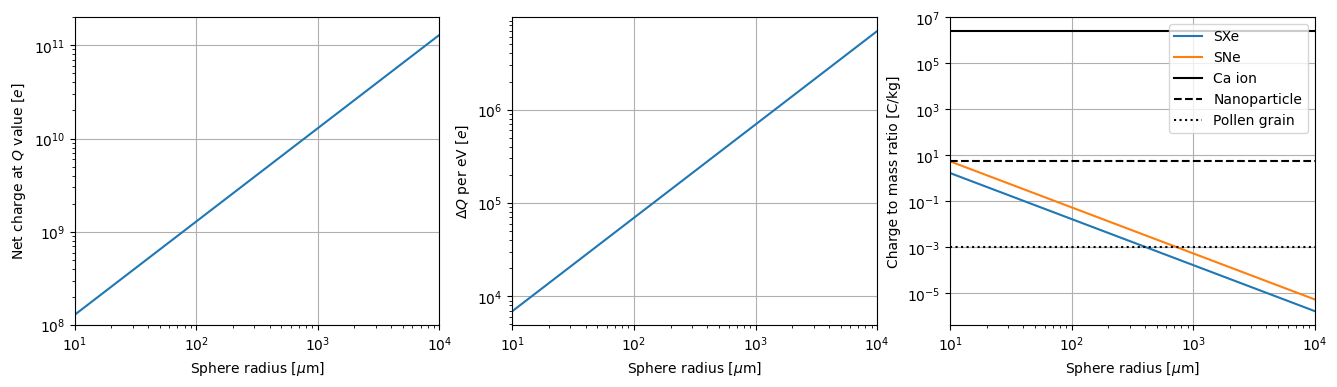

In [901]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.loglog(r0_list, q_Q)
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Net charge at $Q$ value [$e$]")
plt.grid(True)
plt.xlim(1e1, 1e4)
plt.ylim(1e8, 2e11)

plt.subplot(1,3,2)
plt.loglog(r0_list, dQ_per_eV)
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("$\Delta Q$ per eV [$e$]")
plt.grid(True)
plt.xlim(1e1, 1e4)

plt.subplot(1,3,3)
plt.loglog(r0_list, Q_to_m_Xe, label="SXe")
plt.loglog(r0_list, Q_to_m_Ne, label="SNe")
plt.plot(r0_list, Ca_Q_to_m*np.ones_like(r0_list), 'k-', label='Ca ion')
plt.plot(r0_list, nano_Q_to_m*np.ones_like(r0_list), 'k--', label='Nanoparticle')
plt.plot(r0_list, pollen_Q_to_m*np.ones_like(r0_list), 'k:', label='Pollen grain')
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Charge to mass ratio [C/kg]")
plt.grid(True)
plt.xlim(1e1, 1e4)
plt.legend()

plt.savefig("plots/charge_vs_radius.pdf", bbox_inches='tight')

plt.show()

In [902]:
## now potential versus distance

norm_r_list = np.logspace(-1, 5, 1000) #um

V_norm = -T_Q * keV_to_eV * np.ones_like(norm_r_list)
V_norm[norm_r_list > 1] *= 1/norm_r_list[norm_r_list > 1]

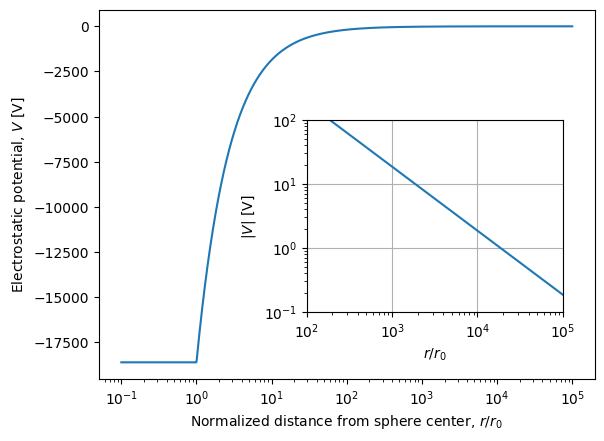

In [903]:
plt.figure()
plt.semilogx(norm_r_list, V_norm)
plt.ylabel("Electrostatic potential, $V$ [V]")
plt.xlabel("Normalized distance from sphere center, $r/r_0$")
ax = plt.gca()

inset_ax = plt.axes([0.45, 0.25, 0.4, 0.4])
inset_ax.loglog(norm_r_list, np.abs(V_norm)) 
inset_ax.set_xlim(100, 100000)
inset_ax.set_ylim(0.1,100)
inset_ax.set_xlabel("$r/r_0$")
inset_ax.set_ylabel("$|V|$ [V]")
inset_ax.grid(True)

plt.savefig("plots/potential_vs_distance.pdf", bbox_inches='tight')

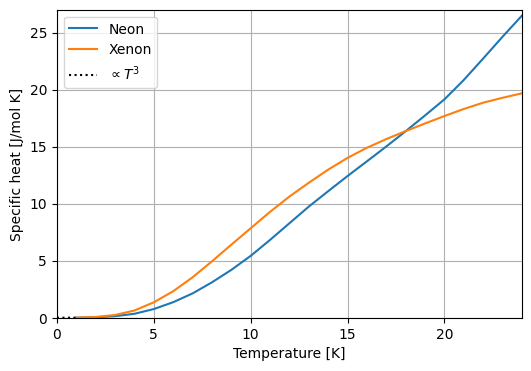

In [904]:
## now some thermal calculations

## columns are T[K], Cp Neon [J/mol K], Cp Xenon [J/mol K]
cs_data = np.loadtxt('cp_solid_ne_xe.csv', delimiter=',', skiprows=3)

plt.figure(figsize=(6,4))
plt.plot(cs_data[:,0], cs_data[:,1], label='Neon')
plt.plot(cs_data[:,0], cs_data[:,2], label='Xenon')
tvals = np.linspace(0,1,1000)
plt.plot(tvals, cs_data[0,1]*tvals**3, 'k:', label='$\propto T^3$')
plt.xlabel("Temperature [K]")
plt.ylabel("Specific heat [J/mol K]")
plt.legend()
ax = plt.gca()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.xlim(0, 24)
plt.ylim(0, 27)
plt.grid(True)
plt.savefig("plots/specific_heat.pdf", bbox_inches='tight')
plt.show()

In [905]:
mass_list_Xe = 4/3 * np.pi * rad_list_um**3 * um_to_cm**3 * solid_Xe_rho # g
mass_list_Ne = 4/3 * np.pi * rad_list_um**3 * um_to_cm**3 * solid_Ne_rho # g

temp = 1 #K
energy = 1 ## eV

temp_rise_Xe = energy * eV_to_J/((mass_list_Xe / Xe_molar_mass) * np.interp(temp, cs_data[:,0], cs_data[:,2], left=0, right=0))# K 
temp_rise_Ne = energy * eV_to_J/((mass_list_Ne / Ne_molar_mass) * np.interp(temp, cs_data[:,0], cs_data[:,1], left=0, right=0))# K 

corr_fac = (0.1/1.0)**3 ## assume T^3 dependence at low temp
temp_rise_Xe_100mK = energy * eV_to_J/((mass_list_Xe / Xe_molar_mass) * corr_fac * np.interp(temp, cs_data[:,0], cs_data[:,2], left=0, right=0))# K 
temp_rise_Ne_100mK = energy * eV_to_J/((mass_list_Ne / Ne_molar_mass) * corr_fac * np.interp(temp, cs_data[:,0], cs_data[:,1], left=0, right=0))# K 


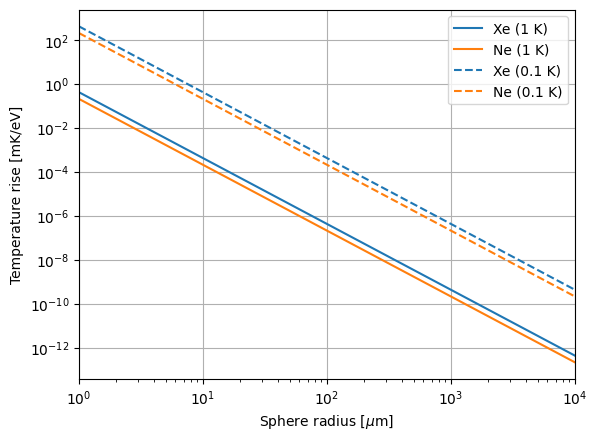

In [906]:
plt.figure()
plt.loglog(rad_list_um, temp_rise_Xe*1e3, color='tab:blue', label='Xe (1 K)')
plt.loglog(rad_list_um, temp_rise_Ne*1e3, color='tab:orange', label='Ne (1 K)')

plt.loglog(rad_list_um, temp_rise_Xe_100mK*1e3, color='tab:blue', ls='--', label='Xe (0.1 K)')
plt.loglog(rad_list_um, temp_rise_Ne_100mK*1e3, color='tab:orange', ls='--', label='Ne (0.1 K)')

plt.grid(True)
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Temperature rise [mK/eV]")
plt.xlim(1, 1e4)
plt.legend()

plt.savefig("plots/temp_rise_vs_radius.pdf", bbox_inches='tight')

plt.show()

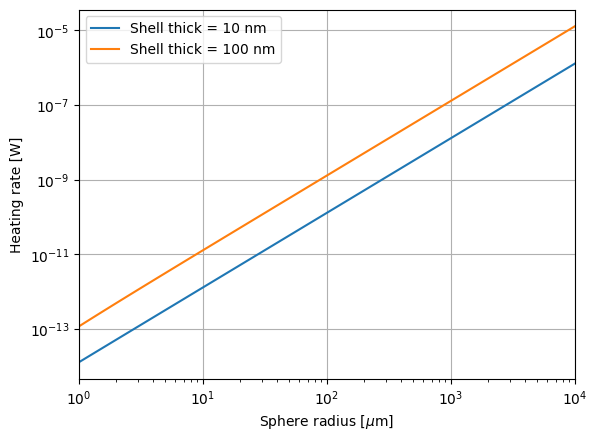

In [907]:
### heating from beta decays versus sphere size

plt.figure()
for thick_idx, thick in enumerate(shell_thick_list):
    plt.loglog(rad_list_um, heating_rate[:, thick_idx], label='Shell thick = %d nm'%(thick*um_to_nm))

plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Heating rate [W]")
plt.grid(True)
plt.legend()
plt.xlim(1,1e4)

plt.savefig("plots/heating_rate_vs_radius.pdf", bbox_inches='tight')
plt.show()

In [908]:
## now the cooling rate versus particle and wall temp
wall_temp = 1 ## K
particle_temp = np.logspace(-1,1,1000) #K

rad_list_um_short = [100, 1000]

im_eps = 1

bb_cooling_mat = np.zeros((len(particle_temp), len(rad_list_um_short)))

for rad_idx, rad in enumerate(rad_list_um_short):
    #https://www.pnas.org/doi/10.1073/pnas.0912969107#supplementary-materials
    volume = 4/3 * np.pi * (rad / m_to_um)**3 # m^3
    cooling = 72*1.04*volume/(np.pi**2 * c_const**3 * hbar**4) * im_eps * (k_b * particle_temp)**5 #W
    heating = 72*1.04*volume/(np.pi**2 * c_const**3 * hbar**4) * im_eps * (k_b * wall_temp)**5 #W
    bb_cooling_mat[:, rad_idx] = cooling - heating


## gas collision cooling

p_list = [1e-3] ## Pa (1 Pa = 1e-2 mbar)

gas_cooling_mat = np.zeros((len(particle_temp), len(rad_list_um_short), len(p_list)))

for p_idx, p in enumerate(p_list):

    for rad_idx, rad in enumerate(rad_list_um_short):

        cooling = 1.5 * p * (rad/m_to_um)**2 * (particle_temp - wall_temp) * np.sqrt((8*np.pi*k_b)/(wall_temp*He_molar_mass*amu_to_g * g_to_kg)) # W
        gas_cooling_mat[:, rad_idx, p_idx] = cooling

In [909]:
## tritium vapor pressure
## constants from https://www.osti.gov/servlets/purl/7110677

A_pa = 10.73882
B = -160.7
Bprime = 2.3235

vapor_press_pa = np.exp(A_pa + B/particle_temp + Bprime*np.log(particle_temp))
sublimation_rate = vapor_press_pa/np.sqrt(2*np.pi*(2*T_molar_mass*amu_to_g*g_to_kg)*k_b*particle_temp)

R = 8.314 ## J/(mol K)
T_Hs = R*(-B + Bprime*particle_temp) ## Tritium heat of sublimation, J/mol

evap_cooling_mat = np.zeros((len(particle_temp), len(rad_list_um_short)))

## now the evaporative cooling rate
for rad_idx, rad in enumerate(rad_list_um_short):
    evap_cooling_mat[:, rad_idx] = 4*np.pi* (rad/m_to_um)**2 * sublimation_rate * T_Hs * 1/(mol_to_atom) # W

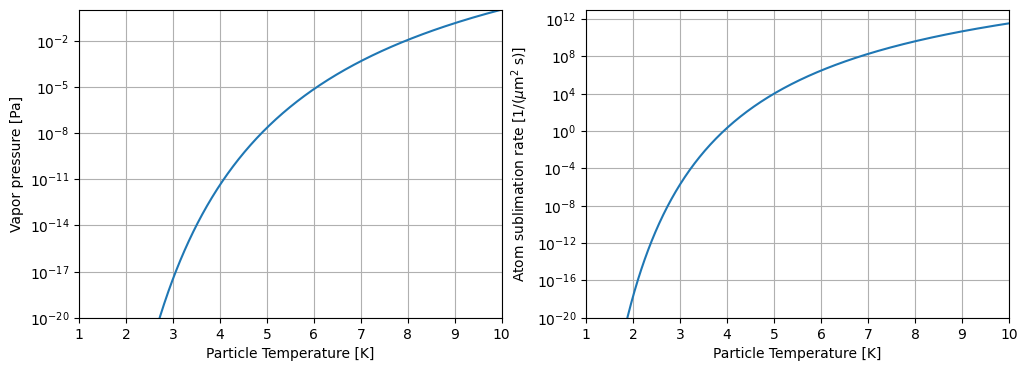

In [910]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogy(particle_temp, vapor_press_pa)
plt.xlim(1, 10)
plt.ylim(1e-20, 1)
plt.xlabel("Particle Temperature [K]")
plt.ylabel("Vapor pressure [Pa]")
plt.grid(True)

plt.subplot(1,2,2)
plt.semilogy(particle_temp, sublimation_rate/(m_to_um**2))
plt.xlim(1, 10)
plt.ylim(1e-20, 1e13)
plt.xlabel("Particle Temperature [K]")
plt.ylabel("Atom sublimation rate [1/($\mu \mathrm{m}^2$ s)]")
plt.grid(True)

plt.savefig("plots/vapor_pressure_vs_temp.pdf", bbox_inches='tight')
plt.show()


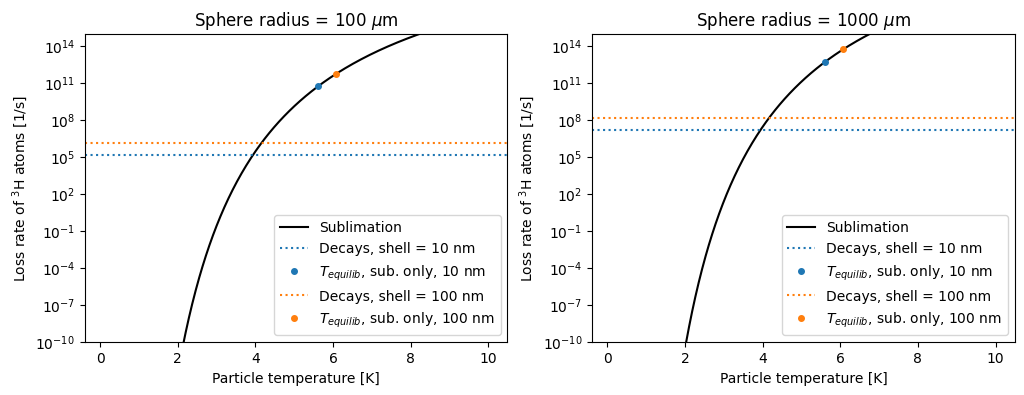

In [911]:
## Tritium loss rate versus temperature

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

for rad_idx, rad in enumerate(rad_list_um_short):
    plt.subplot(1,2,rad_idx+1)

    t_loss_rate = 4*np.pi * rad**2 * sublimation_rate/(m_to_um**2)
    plt.semilogy(particle_temp, t_loss_rate, 'k', label="Sublimation")

    for thick_idx, thick in enumerate(shell_thick_list):        
        mass = 4/3 * np.pi * (rad**3 - (rad-thick)**3) * um_to_cm**3 * solid_T_rho # g
        decay_rate = mass / (T_molar_mass * amu_to_g * T_tau) 
        plt.axhline(decay_rate, color=cols[thick_idx], ls=':', label="Decays, shell = %d nm"%(thick*um_to_nm))

        xval = intersections[rad_idx, thick_idx]
        yval = np.interp(xval, particle_temp, t_loss_rate)
        plt.plot(xval, yval, 'o', color=cols[thick_idx], markersize=4, label='$T_{equilib}$, sub. only, %d nm'%(thick*um_to_nm))
    
    plt.ylim(1e-10, 1e15)
    
    plt.xlabel("Particle temperature [K]")
    plt.ylabel("Loss rate of $^3$H atoms [1/s]")
    plt.legend()

    plt.title("Sphere radius = %d $\mu$m"%(rad))

plt.savefig("plots/loss_rate_vs_temp.pdf", bbox_inches='tight')
plt.show()

In [912]:
## As Mike pointed out, likely the low energy electrons can't make it through a He buffer gas. So, what if we instead condense a He layer
## on the surface of the particle (the extreme version of a differentially pumped volume)

## first, the vapor pressure for He:

## From: https://www.govinfo.gov/content/pkg/GOVPUB-C13-5acaa32352b3605dafcec321793dd649/pdf/GOVPUB-C13-5acaa32352b3605dafcec321793dd649.pdf
## Fitting function: ln P = Sum_i={1,14} B_i T^(2-i)

B_i = np.loadtxt('lhe_vapor_press_coeff.csv', delimiter=',', skiprows=3, usecols=1) # 14 coefficients

lhe_trange = np.linspace(0.5, 2.1, 1001)

ln_p = np.zeros_like(lhe_trange)
for i in range(len(B_i)):
    idx = i + 1
    ln_p += B_i[i] * lhe_trange**(2-idx)

vapor_press_He_um_Hg = np.exp(ln_p) ## um Hg
vapor_press_He_Pa = vapor_press_He_um_Hg * umHg_to_Pa # convert from um Hg to Pa (1 um Hg = 0.133322368421 Pa)
vapor_press_He_bar = vapor_press_He_Pa * Pa_to_bar 

vapor_pressure_He_vals = np.loadtxt('lhe_vapor_press_vals.csv', delimiter=',', skiprows=3)
vapor_press_He_Pa_interp = np.exp(np.interp(particle_temp, vapor_pressure_He_vals[:,0], np.log(vapor_pressure_He_vals[:,1])))/Pa_to_bar

sublimation_rate_He = vapor_press_He_Pa_interp/np.sqrt(2*np.pi*(He_molar_mass*amu_to_g*g_to_kg)*k_b*particle_temp)

## heat of vaporization from: https://www.yutopian.com/Yuan/HeII.html
dT = (particle_temp[1]-particle_temp[0])
He_H_s = R*particle_temp**2/vapor_press_He_Pa_interp * np.gradient(vapor_press_He_Pa_interp, dT) # J/mol, this is the heat of vaporization for He-II
He_H_s[particle_temp > 2.1] = np.nan ## extrap doesn't work out of superfluid phase

evap_cooling_mat_He = np.zeros((len(particle_temp), len(rad_list_um_short)))

for rad_idx, rad in enumerate(rad_list_um_short):
    evap_cooling_mat_He[:, rad_idx] = 4*np.pi* (rad/m_to_um)**2 * sublimation_rate_He * He_H_s * 1/(mol_to_atom) # W

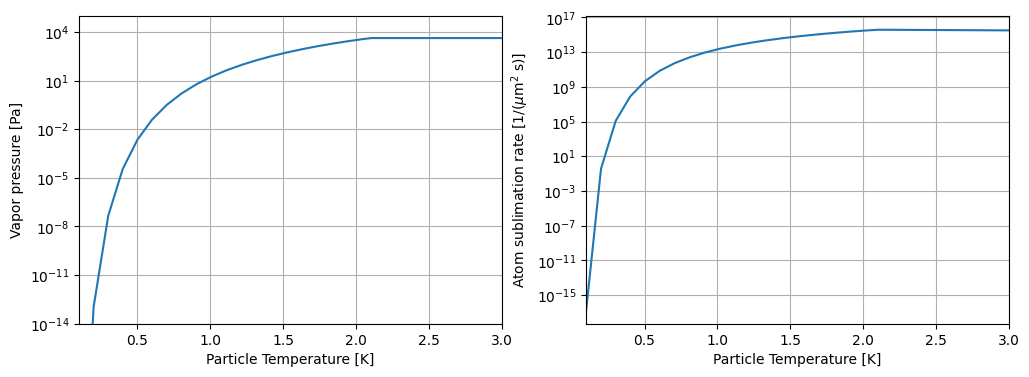

In [913]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
#plt.semilogy(lhe_trange, vapor_press_He_Pa)
#plt.semilogy(vapor_pressure_He_vals[:,0], vapor_pressure_He_vals[:,1]/Pa_to_bar, 'ro', markersize=4) # check against tabulated values
plt.semilogy(particle_temp, vapor_press_He_Pa_interp)
plt.xlim(0.1, 3)
plt.ylim(1e-14, 1e5)
plt.xlabel("Particle Temperature [K]")
plt.ylabel("Vapor pressure [Pa]")
plt.grid(True)

plt.subplot(1,2,2)
plt.semilogy(particle_temp, sublimation_rate_He/(m_to_um**2))
plt.xlim(0.1, 3)
#plt.ylim(1e-20, 1e13)
plt.xlabel("Particle Temperature [K]")
plt.ylabel("Atom sublimation rate [1/($\mu \mathrm{m}^2$ s)]")
plt.grid(True)

plt.savefig("plots/vapor_pressure_He_vs_temp.pdf", bbox_inches='tight')
plt.show()

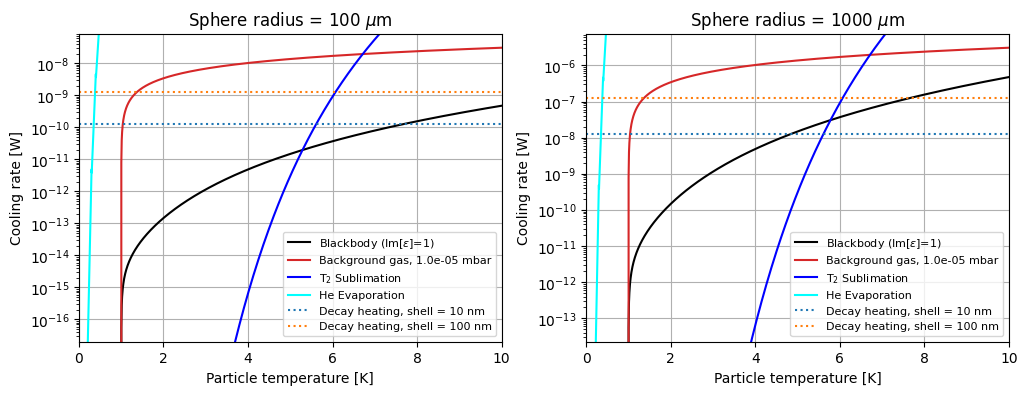

In [914]:
cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

intersections = np.zeros((len(rad_list_um_short), len(shell_thick_list)))
intersections_He = np.zeros((len(rad_list_um_short), len(shell_thick_list)))
plt.figure(figsize=(12, 4))
for rad_idx, rad in enumerate(rad_list_um_short):
    plt.subplot(1,2,rad_idx+1)
    plt.semilogy(particle_temp, bb_cooling_mat[:, rad_idx], color='k', label=r"Blackbody (Im[$\epsilon$]=1)")
    
    for p_idx, p in enumerate(p_list):
        plt.semilogy(particle_temp, gas_cooling_mat[:, rad_idx, p_idx], color='tab:red', label='Background gas, %.1e mbar'%(p*1e-2))

    plt.grid(True)

    yy = plt.ylim()
    plt.semilogy(particle_temp, evap_cooling_mat[:, rad_idx], color='blue', label='T$_2$ Sublimation')
    #plt.ylim(1e-15, 1e15)
    plt.ylim(yy)

    plt.semilogy(particle_temp, evap_cooling_mat_He[:, rad_idx], color='cyan', label='He Evaporation')

    for thick_idx, thick in enumerate(shell_thick_list):
        curr_decay_heating = np.interp(rad, rad_list_um, heating_rate[:, thick_idx])
        plt.axhline(curr_decay_heating, color=cols[thick_idx], ls=':', label="Decay heating, shell = %d nm"%(thick*um_to_nm))

        intersections[rad_idx, thick_idx] = np.interp(curr_decay_heating, evap_cooling_mat[:, rad_idx], particle_temp)
        intersections_He[rad_idx, thick_idx] = np.interp(curr_decay_heating, evap_cooling_mat_He[:, rad_idx], particle_temp)

    plt.xlabel("Particle temperature [K]")
    plt.ylabel("Cooling rate [W]")
    plt.legend(fontsize=8)
    plt.xlim(0,10)
    plt.title("Sphere radius = %d $\mu$m"%(rad))

plt.savefig("plots/cooling_rate_vs_temp.pdf", bbox_inches='tight')
plt.show()


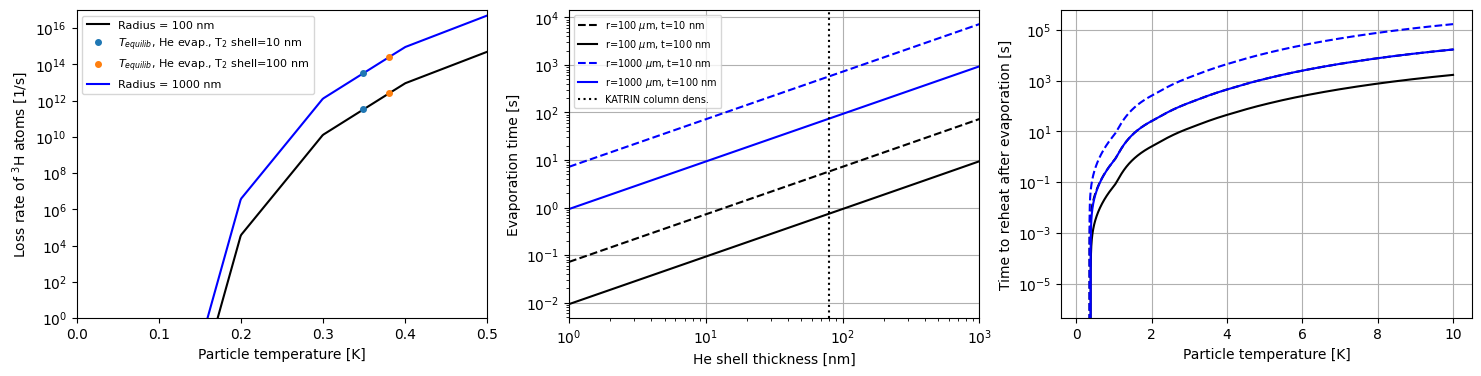

In [915]:
## Helium loss rate versus temperature

plt.figure(figsize=(18,4))

colors = ['k', 'b']

for rad_idx, rad in enumerate(rad_list_um_short):

    plt.subplot(1,3,1)
    he_loss_rate = 4*np.pi * rad**2 * sublimation_rate_He/(m_to_um**2)
    plt.semilogy(particle_temp, he_loss_rate, colors[rad_idx], label="Radius = %d nm"%(rad))

    for thick_idx, thick in enumerate(shell_thick_list):        
        mass = 4/3 * np.pi * (rad**3 - (rad-thick)**3) * um_to_cm**3 * solid_T_rho # g
        #decay_rate = mass / (T_molar_mass * amu_to_g * T_tau) 
        #plt.axhline(decay_rate, color=cols[thick_idx], ls=':', label="Decays, shell = %d nm"%(thick*um_to_nm))

        xval = intersections_He[rad_idx, thick_idx]
        yval = np.interp(xval, particle_temp, he_loss_rate)
        plt.subplot(1,3,1)
        if(rad_idx ==0):
            plt.plot(xval, yval, 'o', color=cols[thick_idx], markersize=4, label='$T_{equilib}$, He evap., T$_2$ shell=%d nm'%(thick*um_to_nm))
        else:
            plt.plot(xval, yval, 'o', color=cols[thick_idx], markersize=4)
    
        init_temp = xval
        time_to_temp_vec = np.zeros_like(particle_temp)
        curr_decay_heating = np.interp(rad, rad_list_um, heating_rate[:, thick_idx]) ## W
        for tidx, temp in enumerate(particle_temp):
            curr_temp_vec = np.linspace(init_temp, temp, 1000)
            curr_cv_vec = np.interp(curr_temp_vec, cs_data[:,0], cs_data[:,2], left=0, right=0)  # Cp Xenon
            low_pts = curr_temp_vec < 1.0
            curr_cv_vec[low_pts] = cs_data[0,2]*curr_temp_vec[low_pts]**3
            int_cv = np.trapz(curr_cv_vec, curr_temp_vec)  # integrate Cp over temperature, units J/mol
            xe_mass = 4/3 * np.pi * (rad)**3 * um_to_cm**3 * solid_Xe_rho # g
            time_to_temp_vec[tidx] = (xe_mass/Xe_molar_mass * int_cv)/curr_decay_heating ## s
        
        if(rad_idx > -1):
            plt.subplot(1,3,3)
            plt.semilogy(particle_temp, time_to_temp_vec, color=colors[rad_idx], linestyle=styles[thick_idx])
            plt.grid(True)

    plt.subplot(1,3,1)
    plt.xlim(0, 0.5)
    plt.ylim(1e0, 1e17)
    
    plt.xlabel("Particle temperature [K]")
    plt.ylabel("Loss rate of He atoms [1/s]")
    plt.legend(fontsize=8)

plt.subplot(1,3,3)
plt.xlabel("Particle temperature [K]")
plt.ylabel("Time to reheat after evaporation [s]")
    #plt.title("Sphere radius = %d $\mu$m"%(rad))

## now the evaporation time versus the thickness of the LHe film

He_shell_thick = np.logspace(-9, -6, 100) ## 0.1 to 1000 nm

plt.subplot(1,3,2)

styles=['--', '-']

for rad_idx, rad in enumerate(rad_list_um_short):
    for thick_idx, thick in enumerate(shell_thick_list):    

        xval = intersections_He[rad_idx, thick_idx]
        loss_rate = np.interp(xval, particle_temp, he_loss_rate)

        ## calculate the number of atoms in a shell of a given thickness
        rad_m = rad/m_to_um # convert to m
        He_mass_vs_thick = 4/3 * np.pi * ((rad_m+He_shell_thick)**3 - rad_m**3) * liquid_He_rho / cm_to_m**3 # g
        He_atoms_vs_thick = He_mass_vs_thick/(He_molar_mass * amu_to_g) # atoms, this is the number of He atoms in a shell of thickness He_shell_thick

        #plt.loglog(He_shell_thick, He_atoms_vs_thick)
        evaporation_time = He_atoms_vs_thick / loss_rate
        plt.loglog(He_shell_thick*m_to_nm, evaporation_time, color=colors[rad_idx], linestyle=styles[thick_idx], label="r=%d $\mu$m, t=%d nm"%(rad, thick*um_to_nm))

        kat_col_dens = np.interp(KATRIN_cd, column_density, thick_list*m_to_um)
        
plt.axvline(kat_col_dens*um_to_nm, color='k', linestyle=':', label='KATRIN column dens.')
plt.xlabel("He shell thickness [nm]")
plt.ylabel("Evaporation time [s]")
plt.grid(True)
plt.xlim(1,1000)
plt.legend(fontsize=7)

plt.savefig("plots/He_loss_rate_vs_temp.pdf", bbox_inches='tight')
plt.show()

In [916]:
## cooling through a thin tether

## thermal conductivity from https://www.sciencedirect.com/science/article/abs/pii/037596017190853X
K_sapph = 40e-3 ## W/K^4*cm


In [917]:
print(np.logspace(-1,0,3))

[0.1        0.31622777 1.        ]
